# Problem

We’re building a simple model to forecast nutritional program intake using food insecurity and demographic data. The goal is to understand how population and economic context relate to participation over time.

# Loading Datasets

Here we're loading all 3 datasets and checking their common columns to merge them

In [6084]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [6085]:
df_intake = pd.read_csv('./data/Nutritional_Programming_West.csv')

C:\Users\Goldencami\AppData\Local\Temp\ipykernel_6900\574217237.py:1: DtypeWarning: Columns (3,4,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_intake = pd.read_csv('./data/Nutritional_Programming_West.csv')


In [6086]:
df_intake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149557 entries, 0 to 149556
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Sex                            111144 non-null  object 
 1   Marital Status                 86940 non-null   object 
 2   Year of Birth                  131425 non-null  float64
 3   Birth Province / Country Code  53135 non-null   object 
 4   Home Province Code             95691 non-null   object 
 5   Creation Date                  128297 non-null  object 
 6   Last Modified                  88018 non-null   object 
 7   employmentstatus_DC            21594 non-null   object 
 8   System_CU                      37245 non-null   object 
 9   City_CU                        29656 non-null   object 
 10  Program_CU                     37245 non-null   object 
 11  Citizenship_CU                 37245 non-null   object 
 12  Primary Diagnosis_CU          

In [6087]:
demographic_df = pd.read_csv('./data/Food_insecurity_selected_demographic_characteristics.csv')

In [6088]:
demographic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   REF_DATE                        156 non-null    int64  
 1   GEO                             156 non-null    object 
 2   DGUID                           156 non-null    object 
 3   Demographic characteristics     156 non-null    object 
 4   Household food security status  156 non-null    object 
 5   Statistics                      156 non-null    object 
 6   UOM                             156 non-null    object 
 7   UOM_ID                          156 non-null    int64  
 8   SCALAR_FACTOR                   156 non-null    object 
 9   SCALAR_ID                       156 non-null    int64  
 10  VECTOR                          156 non-null    object 
 11  COORDINATE                      156 non-null    object 
 12  VALUE                           152 

In [6089]:
economic_df = pd.read_csv('./data/Food_insecurity_economic_family_type.csv')

In [6090]:
economic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   REF_DATE                        108 non-null    int64  
 1   GEO                             108 non-null    object 
 2   DGUID                           108 non-null    object 
 3   Economic family type            108 non-null    object 
 4   Household food security status  108 non-null    object 
 5   Statistics                      108 non-null    object 
 6   UOM                             108 non-null    object 
 7   UOM_ID                          108 non-null    int64  
 8   SCALAR_FACTOR                   108 non-null    object 
 9   SCALAR_ID                       108 non-null    int64  
 10  VECTOR                          108 non-null    object 
 11  COORDINATE                      108 non-null    object 
 12  VALUE                           108 

# Data Transformations

Make the datasets compatible so they can be merged later.

## Nutritional Programming

In [6091]:
# Drop rows that are not associated with Nutritional Programming - West
df_intake = df_intake[df_intake['Program_CU'] == 'Nutritional Programming - West']

In [6092]:
# Convert Creation Date to a year
df_intake['Creation Date'] = pd.to_datetime(df_intake['Creation Date'], errors='coerce')
# Convert year into numerical
df_intake['Year'] = df_intake['Creation Date'].dt.year.astype('Int64')


In [6093]:
# Convert year into numerical
df_intake['Year of Birth'] = df_intake['Year of Birth'].astype('Int64')

In [6094]:
df_intake.drop(columns=['Last Modified'], inplace=True)

In [6095]:
# Replace Nan values
df_intake = df_intake.fillna({
    'Sex': 'Unknown',
    'Marital Status': 'Unknown',
    'Culture_CU': 'Unknown',
    'Sex': 'Unknown',
    'employmentstatus_DC': 'Unknown',
    'Culture_CU': 'Unknown',
})

In [6096]:
df_intake.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 114814 to 114903
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Sex                            90 non-null     object        
 1   Marital Status                 90 non-null     object        
 2   Year of Birth                  90 non-null     Int64         
 3   Birth Province / Country Code  0 non-null      object        
 4   Home Province Code             0 non-null      object        
 5   Creation Date                  90 non-null     datetime64[ns]
 6   employmentstatus_DC            90 non-null     object        
 7   System_CU                      90 non-null     object        
 8   City_CU                        4 non-null      object        
 9   Program_CU                     90 non-null     object        
 10  Citizenship_CU                 90 non-null     object        
 11  Primary Diagnosis

### Intake trend

In [6097]:
df_intake2 = df_intake[['Sex', 'Culture_CU', 'Year']].dropna()
grouped_creation = df_intake2.groupby(['Sex', 'Culture_CU', 'Year']).size().reset_index(name='Count')
grouped_creation.sort_values('Year', inplace=True)
print(grouped_creation)

                Sex                Culture_CU  Year  Count
0     Cisgender Man                   African  2014      2
1     Cisgender Man                  Canadian  2014      5
11  Cisgender Woman                  Canadian  2014      5
17  Cisgender Woman                 Caribbean  2014      1
10  Cisgender Woman  Aboriginal/First Nations  2015      1
12  Cisgender Woman                  Canadian  2015      7
21  Cisgender Woman                  European  2015      2
2     Cisgender Man                  Canadian  2015      8
25  Cisgender Woman                   Unknown  2015      5
13  Cisgender Woman                  Canadian  2016      4
26  Cisgender Woman                   Unknown  2016      4
24  Cisgender Woman  Preferred not to Specify  2016      3
20  Cisgender Woman                East Asian  2016      1
8     Cisgender Man                  European  2016      3
7     Cisgender Man                East Asian  2016      1
3     Cisgender Man                  Canadian  2016     

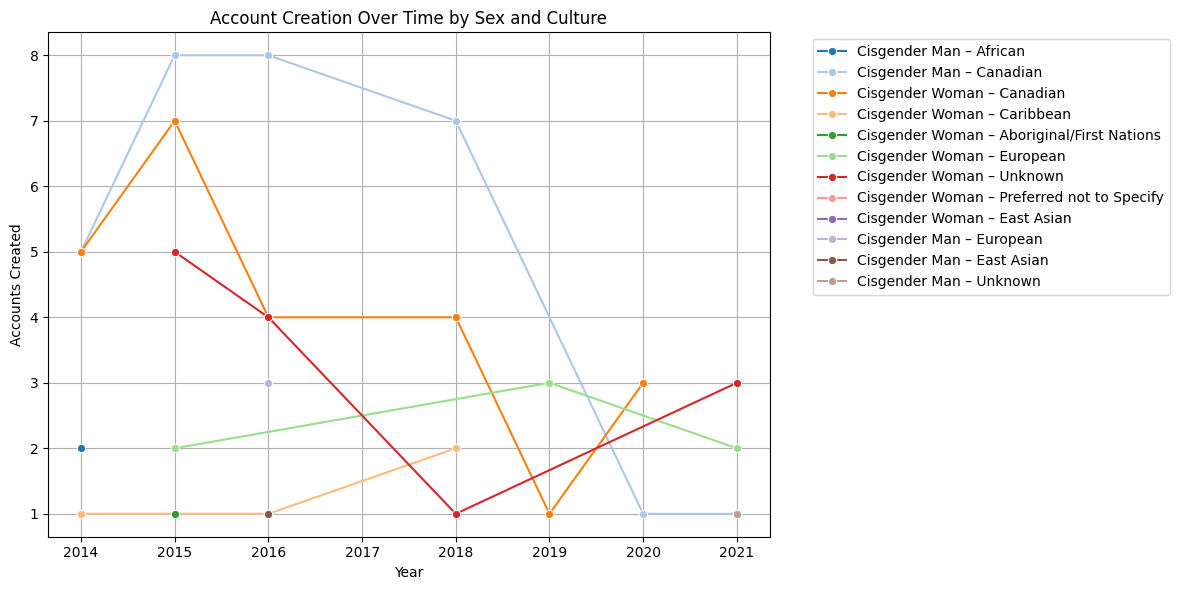

In [6098]:
groups = list(grouped_creation.groupby(['Sex', 'Culture_CU']))

plt.figure(figsize=(12, 6))

grouped_creation['Sex_Culture'] = grouped_creation['Sex'] + " – " + grouped_creation['Culture_CU']

sns.lineplot(
    data=grouped_creation,
    x='Year',
    y='Count',
    hue='Sex_Culture',
    marker='o',
    palette='tab20'
)

plt.title('Account Creation Over Time by Sex and Culture')
plt.xlabel('Year')
plt.ylabel('Accounts Created')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

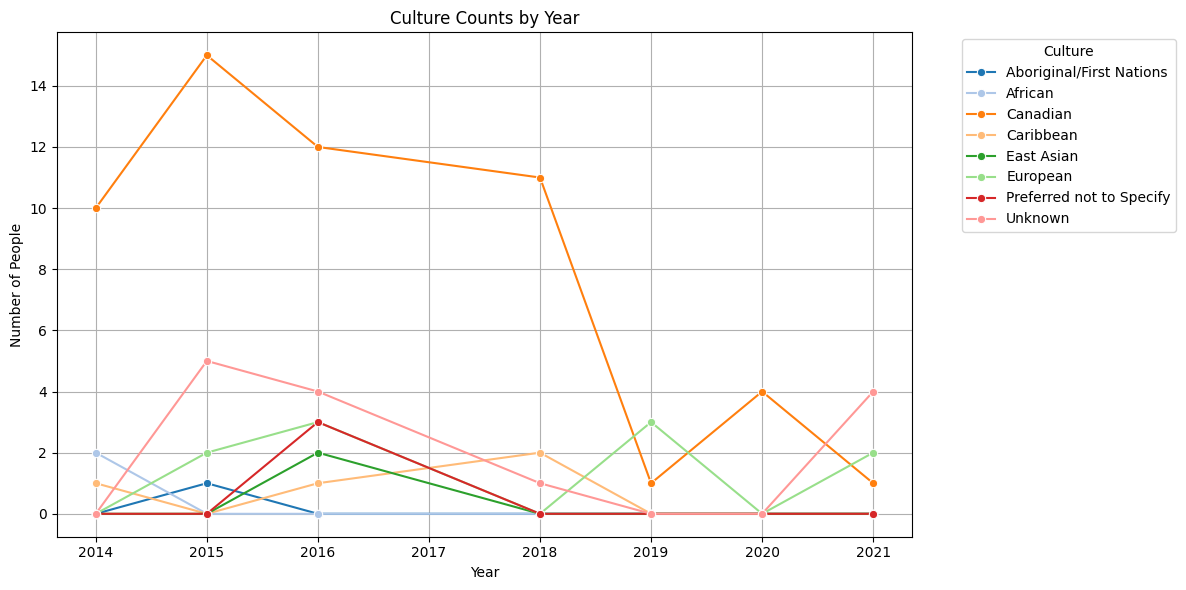

In [6099]:
df_subscriptions_count = df_intake.groupby(['Year', 'Culture_CU']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
df_long = df_subscriptions_count.reset_index().melt(id_vars='Year', var_name='Culture_CU', value_name='Count')

sns.lineplot(
    data=df_long,
    x='Year',
    y='Count',
    hue='Culture_CU',
    marker='o',
    palette='tab20'
)

plt.xlabel('Year')
plt.ylabel('Number of People')
plt.title('Culture Counts by Year')
plt.legend(title='Culture', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [6100]:
grouped_sex_citizen = df_intake.groupby(['Citizenship_CU', 'Sex']).size().reset_index(name='Count')
print(grouped_sex_citizen)

     Citizenship_CU              Sex  Count
0  Canadian Citizen    Cisgender Man     37
1  Canadian Citizen  Cisgender Woman     43
2  Landed Immigrant  Cisgender Woman      7
3     None Selected  Cisgender Woman      3


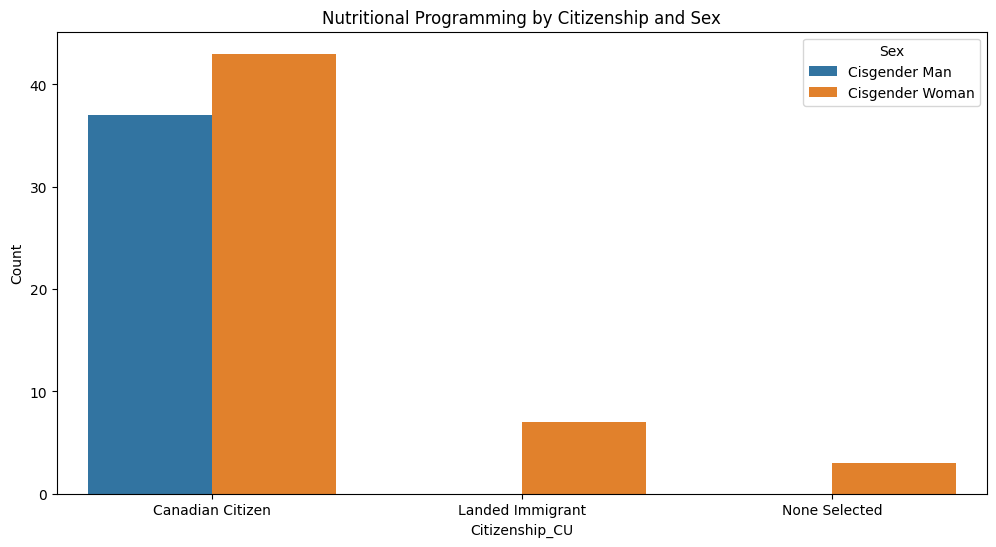

In [6101]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Citizenship_CU', y='Count', hue='Sex', data=grouped_sex_citizen)
plt.title('Nutritional Programming by Citizenship and Sex')
plt.show()

In [6102]:
grouped_sex_marital = df_intake.groupby(['Marital Status', 'Sex']).size().reset_index(name='Count')
print(grouped_sex_marital)

  Marital Status              Sex  Count
0     Common Law  Cisgender Woman      1
1       Divorced    Cisgender Man      4
2       Divorced  Cisgender Woman      1
3        Married    Cisgender Man      2
4  None Selected    Cisgender Man      1
5  None Selected  Cisgender Woman     11
6         Single    Cisgender Man     26
7         Single  Cisgender Woman     24
8        Unknown    Cisgender Man      4
9        Unknown  Cisgender Woman     16


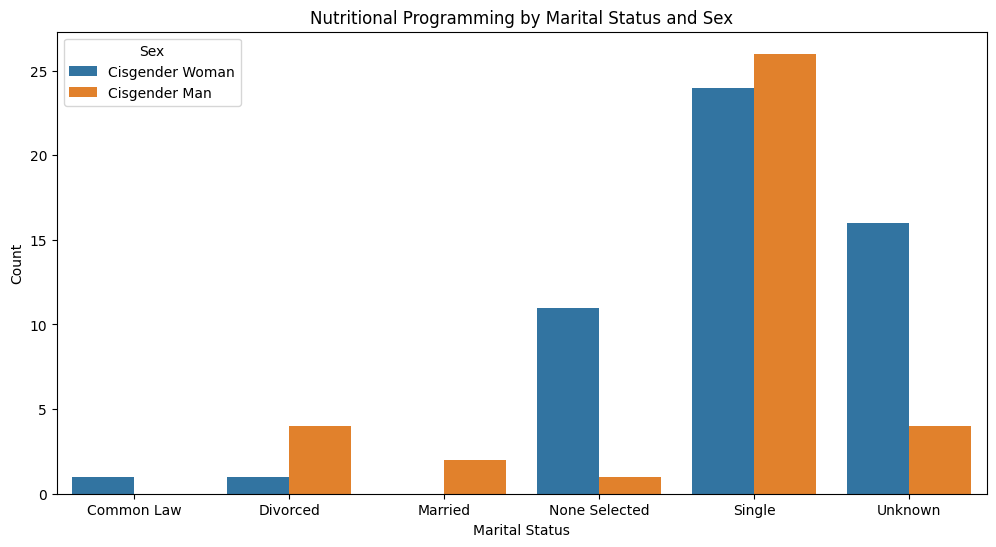

In [6103]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Marital Status', y='Count', hue='Sex', data=grouped_sex_marital)
plt.title('Nutritional Programming by Marital Status and Sex')
plt.show()

In [6104]:
grouped_sex_culture = df_intake.groupby(['Culture_CU', 'Sex']).size().reset_index(name='Count')
print(grouped_sex_culture)

                  Culture_CU              Sex  Count
0   Aboriginal/First Nations  Cisgender Woman      1
1                    African    Cisgender Man      2
2                   Canadian    Cisgender Man     30
3                   Canadian  Cisgender Woman     24
4                  Caribbean  Cisgender Woman      4
5                 East Asian    Cisgender Man      1
6                 East Asian  Cisgender Woman      1
7                   European    Cisgender Man      3
8                   European  Cisgender Woman      7
9   Preferred not to Specify  Cisgender Woman      3
10                   Unknown    Cisgender Man      1
11                   Unknown  Cisgender Woman     13


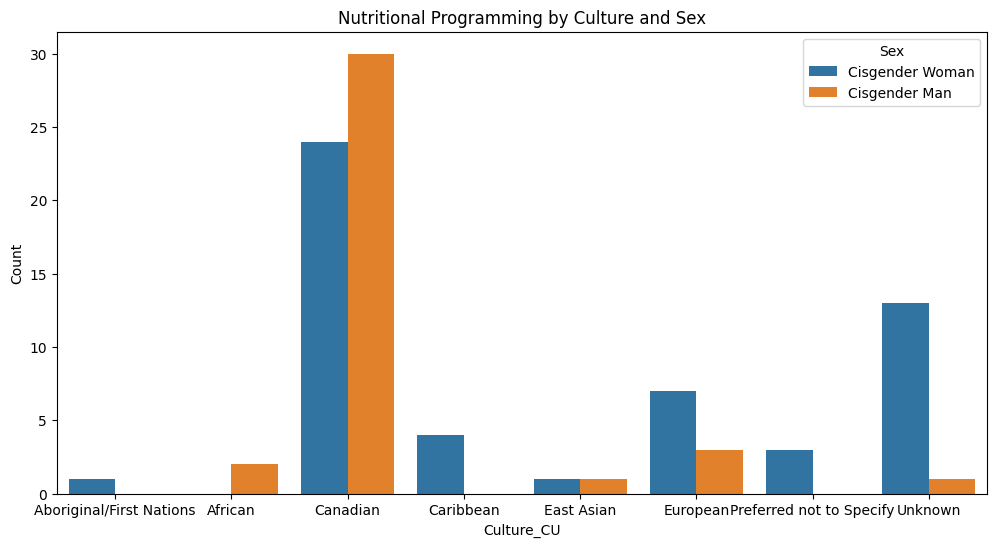

In [6105]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Culture_CU', y='Count', hue='Sex', data=grouped_sex_culture)
plt.title('Nutritional Programming by Culture and Sex')
plt.show()

## Demographic dataset

In [6106]:
demographic_cols_drop = [
    'DGUID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL',
    'TERMINATED', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID',
    'Statistics', 'UOM', 'DECIMALS'
]
demographic_df.drop(columns=[c for c in demographic_cols_drop if c in demographic_df.columns], inplace=True)

In [6107]:
rename_demographic = {
    'REF_DATE': 'Year',
    'GEO': 'Region',
    'Demographic characteristics': 'Demographic',
    'Household food security status': 'FoodSecurityStatus',
    'VALUE': 'Demographic_Value',
}
demographic_df.rename(columns=rename_demographic, inplace=True)

In [6108]:
demographic_df['Year'] = pd.to_numeric(demographic_df['Year'], errors='coerce')
demographic_df['Demographic_Value'] = pd.to_numeric(demographic_df['Demographic_Value'], errors='coerce')

In [6109]:
demographic_df.head()

,Year,Region,Demographic,FoodSecurityStatus,Demographic_Value
0,2018,Canada,All persons,Food insecure,16.8
1,2019,Canada,All persons,Food insecure,15.9
2,2020,Canada,All persons,Food insecure,15.7
3,2021,Canada,All persons,Food insecure,18.4
4,2022,Canada,All persons,Food insecure,22.9


### Demographic Trend

In [6110]:
# Pivot table so each demographic is a column
demographic_pivot = demographic_df.pivot_table(
    index='Year',
    columns='Demographic',
    values='Demographic_Value',
    aggfunc='sum'
).reset_index()

In [6111]:
age_order = [
    'Persons under 18 years',
    'Persons 18 to 24 years',
    'Persons 25 to 34 years',
    'Persons 35 to 44 years',
    'Persons 45 to 54 years',
    'Persons 55 to 64 years',
    'Persons 65 years and over'
]

In [6112]:
# Sort columns: age groups first in order, then any other demographics
demographic_cols = [col for col in age_order if col in demographic_pivot.columns] + \
                   [col for col in demographic_pivot.columns if col not in age_order + ['Year']]

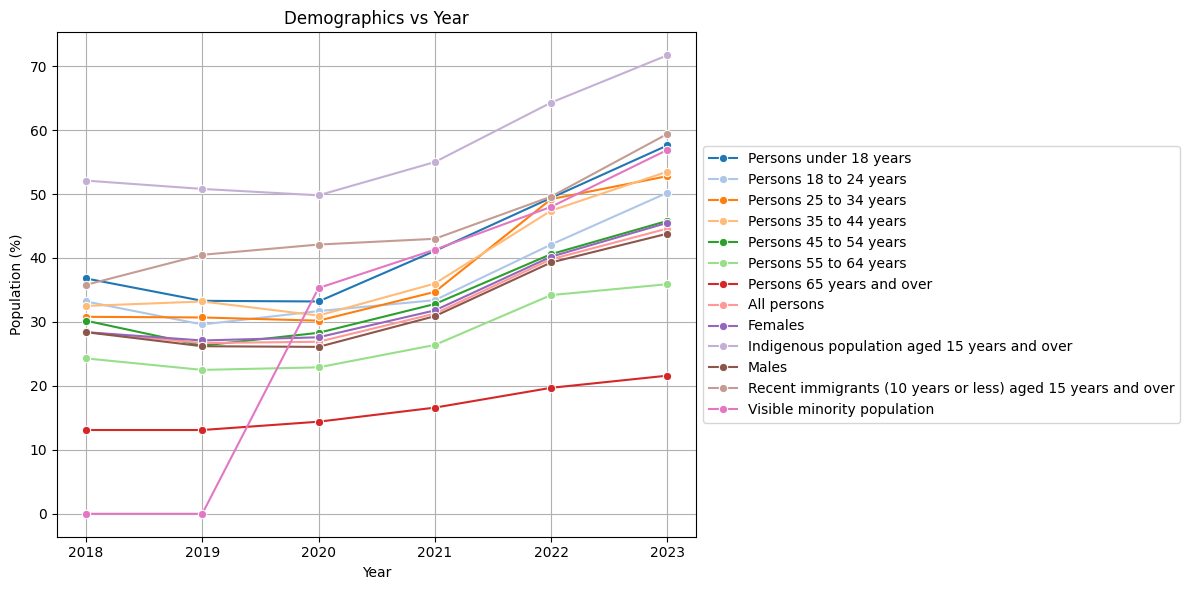

In [6113]:
plt.figure(figsize=(12, 6))

demographic_long = demographic_pivot.reset_index().melt(
    id_vars='Year',
    value_vars=demographic_cols,
    var_name='Demographic',
    value_name='Percentage'
)

sns.lineplot(
    data=demographic_long,
    x='Year',
    y='Percentage',
    hue='Demographic',
    marker='o',
    palette='tab20'
)

plt.xlabel('Year')
plt.ylabel('Population (%)')
plt.title('Demographics vs Year')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

## Economic dataset

In [6114]:
economic_cols_drop = [
    'DGUID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL',
    'TERMINATED', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID',
    'Statistics', 'UOM', 'DECIMALS'
]
economic_df.drop(columns=[c for c in economic_cols_drop if c in economic_df.columns], inplace=True)


In [6115]:
rename_economic = {
    'REF_DATE': 'Year',
    'GEO': 'Region',
    'Economic family type': 'EconomicType',
    'Household food security status': 'FoodSecurityStatus',
    'VALUE': 'Economic_Value',
}
economic_df.rename(columns=rename_economic, inplace=True)

In [6116]:
economic_df['Year'] = pd.to_numeric(economic_df['Year'], errors='coerce')
economic_df['Economic_Value'] = pd.to_numeric(economic_df['Economic_Value'], errors='coerce')

In [6117]:
economic_df.head()

,Year,Region,EconomicType,FoodSecurityStatus,Economic_Value
0,2018,Canada,All persons,Food insecure,16.8
1,2019,Canada,All persons,Food insecure,15.9
2,2020,Canada,All persons,Food insecure,15.7
3,2021,Canada,All persons,Food insecure,18.4
4,2022,Canada,All persons,Food insecure,22.9


### Economic Trend

In [6118]:
# Pivot table so each demographic is a column
economic_pivot = economic_df.pivot_table(
    index='Year',
    columns='EconomicType',
    values='Economic_Value',
    aggfunc='sum'
).reset_index()

In [6119]:
economic_order = [
    'EconomicType_Non-seniors not in an economic family',
    'EconomicType_Persons in couple families with children',
    'EconomicType_Persons in economic families',
    'EconomicType_Persons in lone-parent families',
    'EconomicType_Persons in non-senior families',
    'EconomicType_Persons in senior families',
    'EconomicType_Persons not in an economic family',
    'EconomicType_Seniors not in an economic family'
]

In [6120]:
# Sort columns: age groups first in order, then any other economics
economic_cols = [col for col in economic_order if col in economic_pivot.columns] + \
                [col for col in economic_pivot.columns if col not in economic_order + ['Year']]

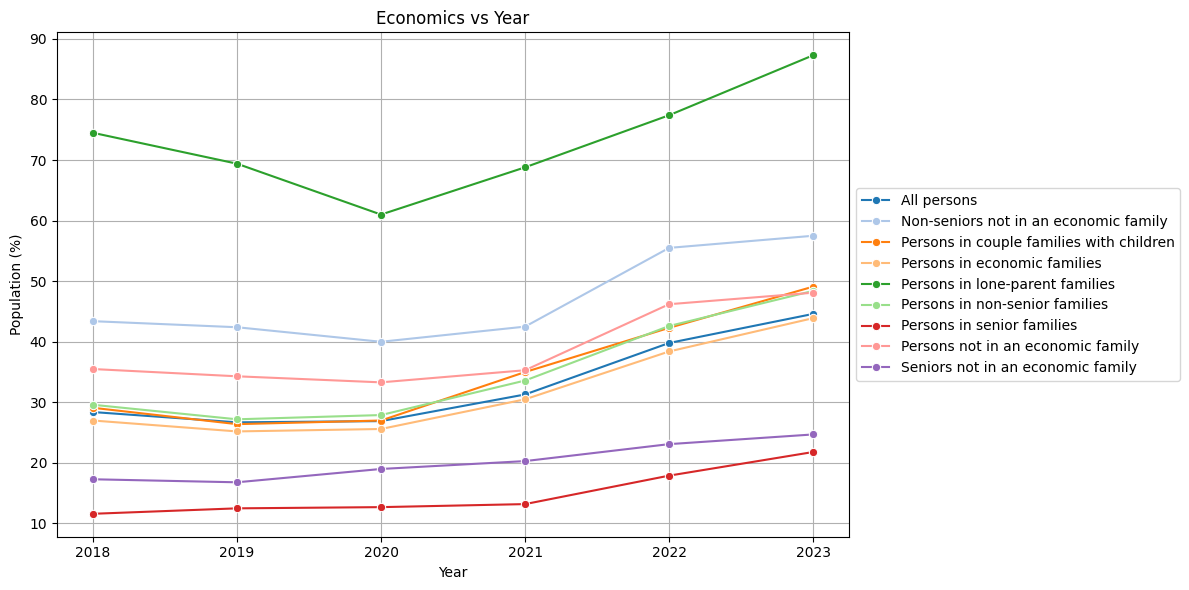

In [6121]:
plt.figure(figsize=(12,6))

economic_long = economic_pivot.reset_index().melt(
    id_vars='Year',
    value_vars=economic_cols,
    var_name='Economic',
    value_name='Percentage'
)

sns.lineplot(
    data=economic_long,
    x='Year',
    y='Percentage',
    hue='Economic',
    marker='o',
    palette='tab20'
)

plt.xlabel('Year')
plt.ylabel('Population (%)')
plt.title('Economics vs Year')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

In [6122]:
# Pivot table so each demographic is a column
insecurity_pivot = economic_df.pivot_table(
    index='Year',
    columns='FoodSecurityStatus',
    values='Economic_Value',
    aggfunc='sum'
).reset_index()

In [6123]:
insecurity_order = [
    'FoodSecurityStatus_Food insecure',
    'FoodSecurityStatus_Food insecure, moderate or severe'
]

In [6124]:
# Sort columns: age groups first in order, then any other economics
insecurity_cols = [col for col in insecurity_order if col in insecurity_pivot.columns] + \
                  [col for col in insecurity_pivot.columns if col not in insecurity_order + ['Year']]

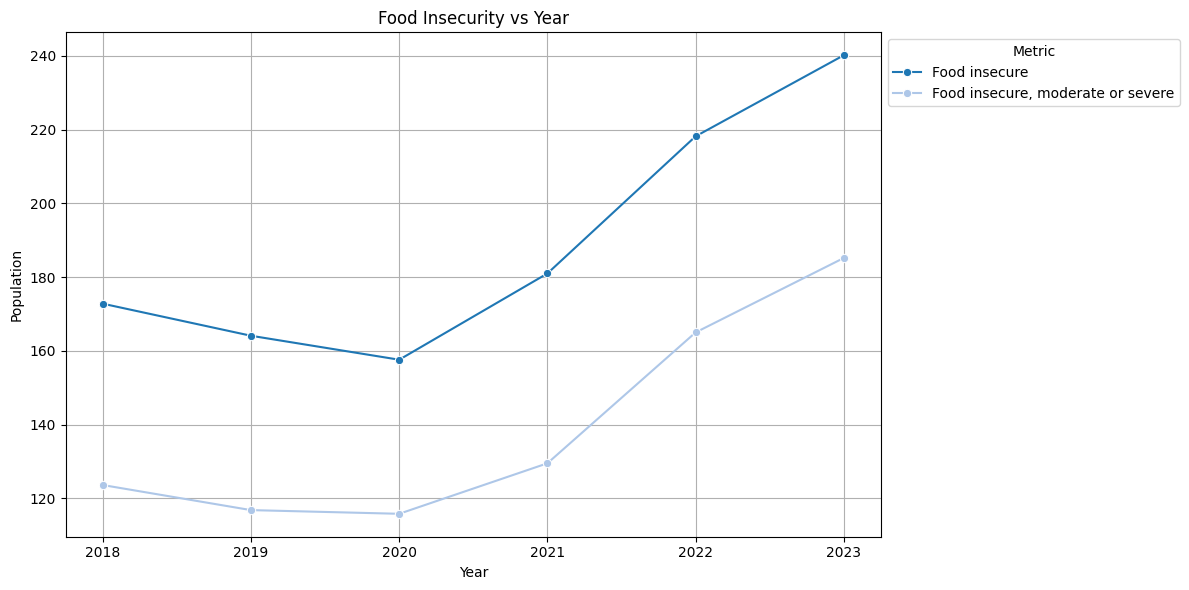

In [6125]:
plt.figure(figsize=(12,6))

insecurity_long = insecurity_pivot.reset_index().melt(
    id_vars='Year',
    value_vars=insecurity_cols,
    var_name='Insecurity_Metric',
    value_name='Population'
)

sns.lineplot(
    data=insecurity_long,
    x='Year',
    y='Population',
    hue='Insecurity_Metric',
    marker='o',
    palette='tab20'
)

plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Food Insecurity vs Year')
plt.legend(title='Metric', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Merging datasets

The only common variables between the 3 datasets is 'Year'

In [6126]:
df_intake_demo = df_intake.merge(
    demographic_df,
    on='Year',
    how='left',
    suffixes=('', '_dem')
)

df_all = df_intake_demo.merge(
    economic_df,
    on='Year',
    how='left',
    suffixes=('', '_econ')
)

In [6127]:
# Convert numeric Year into same data type
df_all = df_all.astype({
    'Year': 'Int64'
})

In [6128]:
# Show which years succesfully merged
df_all['Year'].unique()

<IntegerArray>
[2015, 2021, 2014, 2018, 2016, 2020, 2019]
Length: 7, dtype: Int64

In [6129]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13633 entries, 0 to 13632
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Sex                            13633 non-null  object        
 1   Marital Status                 13633 non-null  object        
 2   Year of Birth                  13633 non-null  Int64         
 3   Birth Province / Country Code  0 non-null      object        
 4   Home Province Code             0 non-null      object        
 5   Creation Date                  13633 non-null  datetime64[ns]
 6   employmentstatus_DC            13633 non-null  object        
 7   System_CU                      13633 non-null  object        
 8   City_CU                        4 non-null      object        
 9   Program_CU                     13633 non-null  object        
 10  Citizenship_CU                 13633 non-null  object        
 11  Primary Diagnos

In [6130]:
# Select numerical columns to check if there are NaN values
numerical_df = df_all.select_dtypes(include=np.number)
np.isnan(numerical_df) # there are NaN values

,Year of Birth,Year,Demographic_Value,Economic_Value
0,False,False,True,True
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
13628,False,False,True,True
13629,False,False,True,True
13630,False,False,True,True
13631,False,False,True,True


In [6131]:
numeric_cols = df_all.select_dtypes(include='number').columns
cat_cols = df_all.select_dtypes(include='object').columns

# For numeric columns: forward-fill, then fill any remaining NaNs with median
df_all[numeric_cols] = df_all[numeric_cols].ffill()
for col in numeric_cols:
    df_all[col] = df_all[col].fillna(df_all[col].median())

# For categorical columns: fill NaNs with 'Unknown'
df_all[cat_cols] = df_all[cat_cols].fillna('Unknown')

In [6132]:
df_all.head()

,Sex,Marital Status,Year of Birth,Birth Province / Country Code,Home Province Code,Creation Date,employmentstatus_DC,System_CU,City_CU,Program_CU,...,Culture_CU,Year,Region,Demographic,FoodSecurityStatus,Demographic_Value,Region_econ,EconomicType,FoodSecurityStatus_econ,Economic_Value
0,Cisgender Woman,Single,1963,Unknown,Unknown,2015-07-20,Unknown,CCU,Toronto,Nutritional Programming - West,...,Canadian,2015,Unknown,Unknown,Unknown,14.8,Unknown,Unknown,Unknown,15.3
1,Cisgender Woman,Single,1958,Unknown,Unknown,2021-10-23,Unknown,CCU,Unknown,Nutritional Programming - West,...,European,2021,Canada,All persons,Food insecure,18.4,Canada,All persons,Food insecure,18.4
2,Cisgender Woman,Single,1958,Unknown,Unknown,2021-10-23,Unknown,CCU,Unknown,Nutritional Programming - West,...,European,2021,Canada,All persons,Food insecure,18.4,Canada,All persons,"Food insecure, moderate or severe",12.9
3,Cisgender Woman,Single,1958,Unknown,Unknown,2021-10-23,Unknown,CCU,Unknown,Nutritional Programming - West,...,European,2021,Canada,All persons,Food insecure,18.4,Canada,Persons in economic families,Food insecure,18.1
4,Cisgender Woman,Single,1958,Unknown,Unknown,2021-10-23,Unknown,CCU,Unknown,Nutritional Programming - West,...,European,2021,Canada,All persons,Food insecure,18.4,Canada,Persons in economic families,"Food insecure, moderate or severe",12.4


In [6133]:
# Transform values into numeric
df_all['Economic_Value'] = pd.to_numeric(df_all['Economic_Value'], errors='coerce')
df_all['Demographic_Value'] = pd.to_numeric(df_all['Demographic_Value'], errors='coerce')

In [6134]:
# One-Hot Encode categorical columns
df_all = pd.get_dummies(
    df_all, 
    columns=['EconomicType', 'Demographic', 'FoodSecurityStatus_econ'], 
    drop_first=True
)

## Prepare for modeling

### Create lag features

In [6135]:
df_yearly = df_all.groupby(
    ['Year', 'Sex', 'Culture_CU', 'Program_CU'],
    as_index=False
).agg({
    'Demographic_Value': 'mean',
    'Economic_Value': 'mean'
})

df_yearly = df_yearly.sort_values(['Sex', 'Culture_CU', 'Program_CU', 'Year'])

# Create 1-year and 2-year lags for Food Insecurity
df_yearly['FoodInsecurity_lag1'] = df_yearly.groupby(
    ['Sex', 'Culture_CU', 'Program_CU']
)['Demographic_Value'].shift(1)

df_yearly['FoodInsecurity_lag2'] = df_yearly.groupby(
    ['Sex', 'Culture_CU', 'Program_CU']
)['Demographic_Value'].shift(2)

# Fill missing lag values with 0
df_yearly[['FoodInsecurity_lag1', 'FoodInsecurity_lag2']] = df_yearly[[
    'FoodInsecurity_lag1', 'FoodInsecurity_lag2'
]].fillna(0)

### Split into train/test sets

In [6136]:
train = df_yearly[df_yearly['Year'] <= 2019]
test  = df_yearly[df_yearly['Year'] >  2019]

### Define features and target

In [6137]:
categorical_cols = ['Sex', 'Culture_CU', 'Program_CU']
target_col = 'Demographic_Value'

In [6138]:
print(train.columns.tolist())

['Year', 'Sex', 'Culture_CU', 'Program_CU', 'Demographic_Value', 'Economic_Value', 'FoodInsecurity_lag1', 'FoodInsecurity_lag2']


### One Hot Encoding

In [6139]:
train = pd.get_dummies(train, columns=categorical_cols)
test  = pd.get_dummies(test, columns=categorical_cols)

# Align columns
train, test = train.align(test, join='left', axis=1, fill_value=0)
feature_cols = [col for col in train.columns if col != target_col]

In [6140]:
X_train, y_train = train[feature_cols], train[target_col]
X_test,  y_test  = test[feature_cols], test[target_col]

### Train a model

In [6141]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Test MSE:', mse)
print('Test RMSE:', np.sqrt(mse))
print('Test R²:', r2_score(y_test, y_pred))

Test MSE: 3.4732728310425123
Test RMSE: 1.863671867857245
Test R²: -2.5183334061588614


R^2 is negative, the predicted data is overfitting. Can be caused by the small dataset of Woodgreen having only 90 rows and not many common variables

### Plot

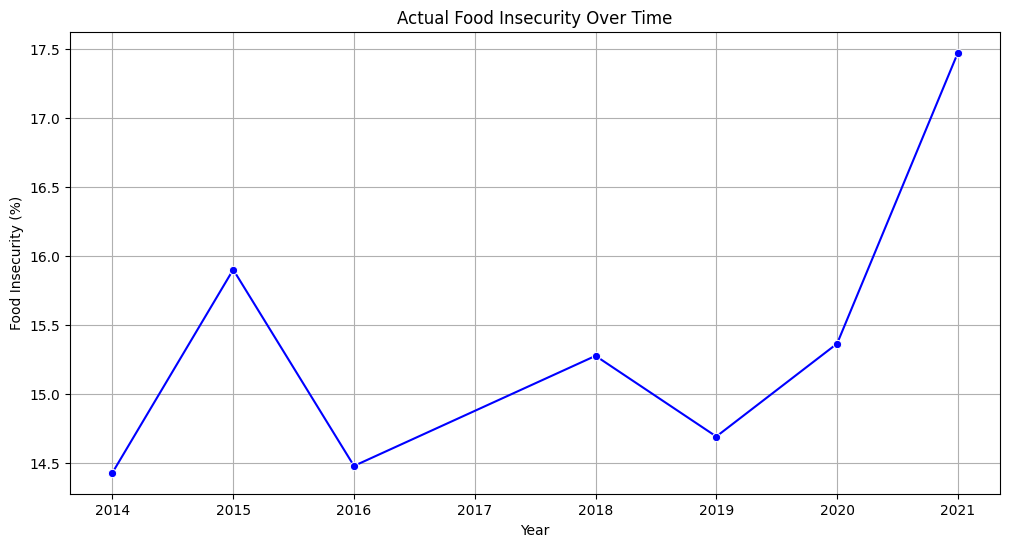

In [6142]:
# Plot actual food insecurity
plt.figure(figsize=(12,6))
sns.lineplot(
    x='Year', 
    y='Demographic_Value', 
    data=df_yearly.groupby('Year')['Demographic_Value'].mean().reset_index(),
    marker='o', color='blue'
)
plt.title('Actual Food Insecurity Over Time')
plt.xlabel('Year')
plt.ylabel('Food Insecurity (%)')
plt.grid(True)
plt.show()

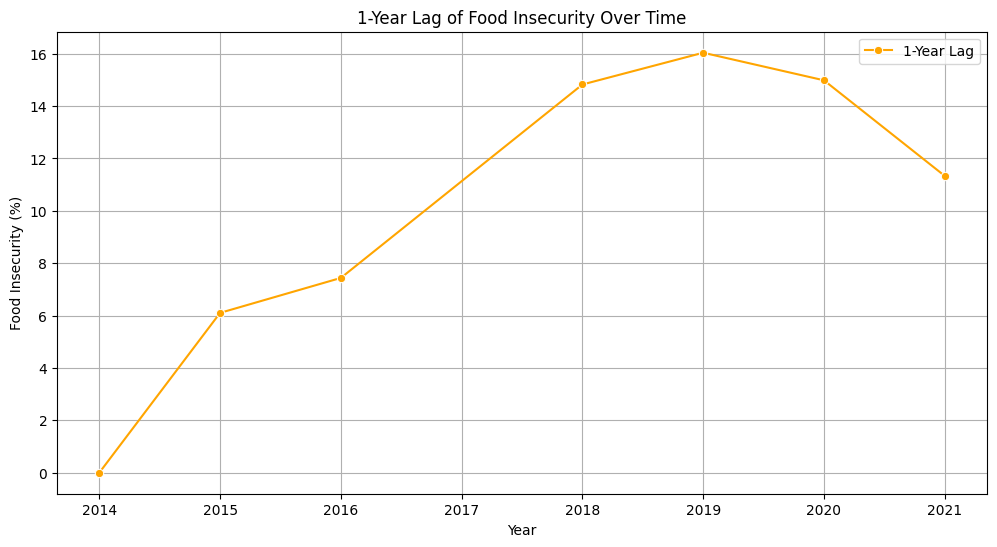

In [6143]:
plt.figure(figsize=(12,6))
sns.lineplot(
    x='Year', 
    y='FoodInsecurity_lag1', 
    data=df_yearly.groupby('Year')['FoodInsecurity_lag1'].mean().reset_index(),
    marker='o', label='1-Year Lag', color='orange'
)
plt.title('1-Year Lag of Food Insecurity Over Time')
plt.xlabel('Year')
plt.ylabel('Food Insecurity (%)')
plt.legend()
plt.grid(True)
plt.show()